In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

img_right = cv2.imread('img_right.jpg')
img_left = cv2.imread('img_left.jpg')

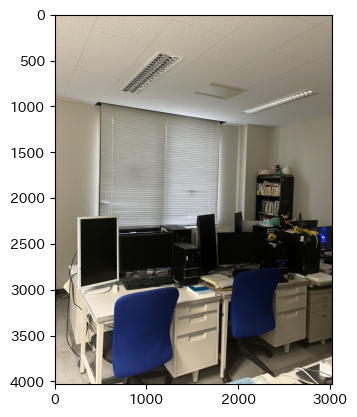

In [11]:
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))

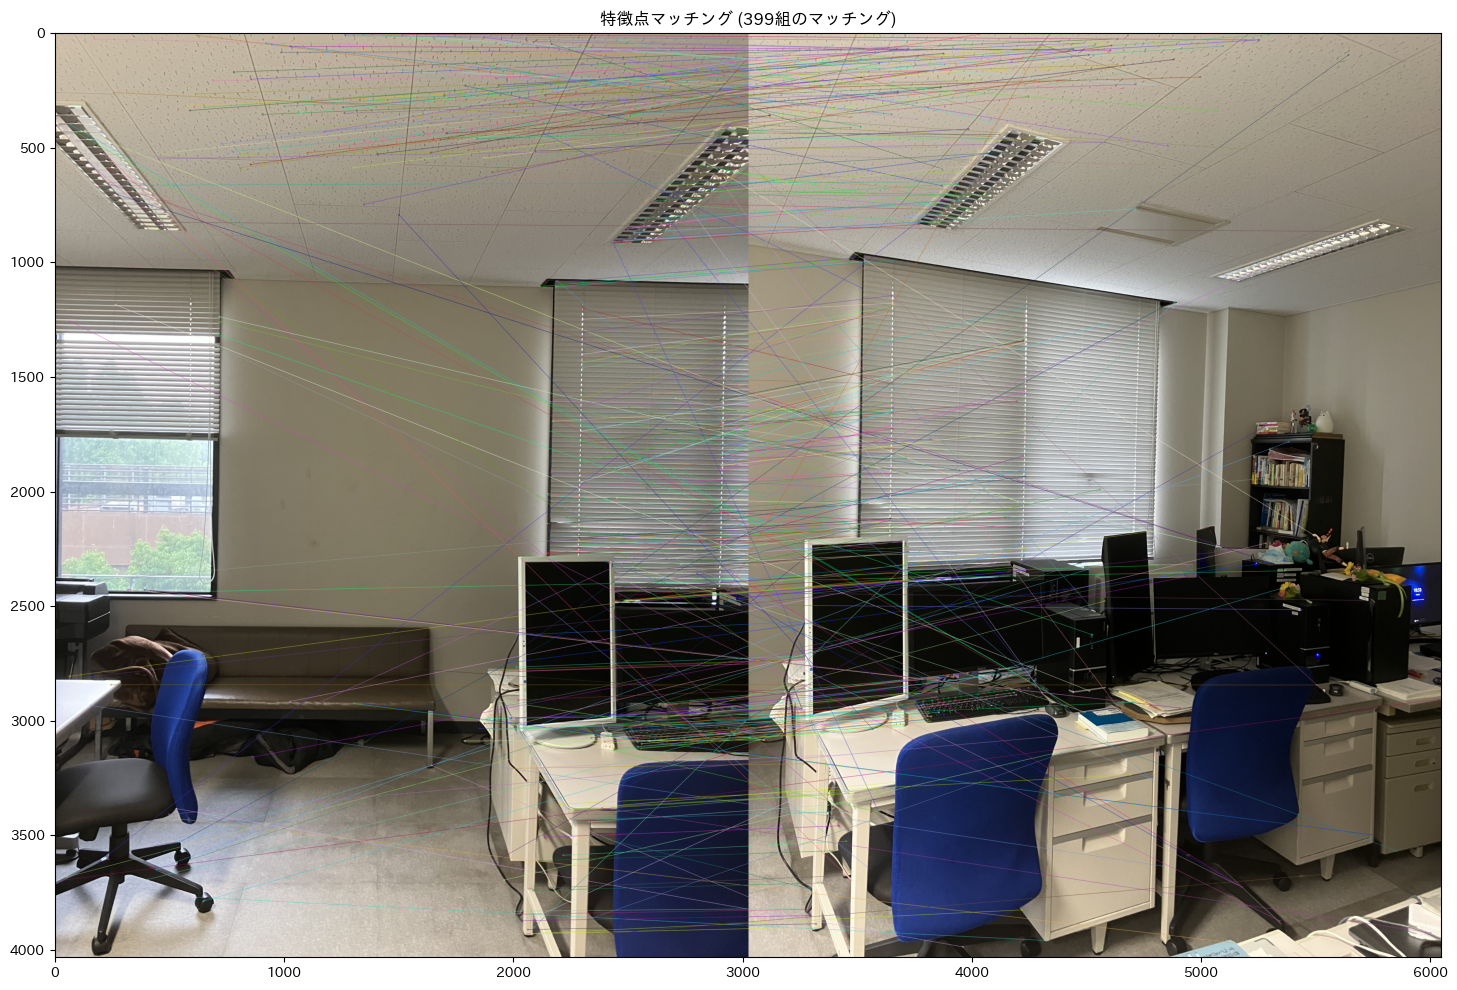

検出された特徴点数：左画像 = 14169, 右画像 = 17944
マッチング数：399


In [12]:
# 画像をグレースケールに変換
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# SIFT検出器の作成
sift = cv2.SIFT_create()

# 特徴点とディスクリプタの検出
kp_left, des_left = sift.detectAndCompute(gray_left, None)
kp_right, des_right = sift.detectAndCompute(gray_right, None)

# BFMatcherの作成
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_left, des_right, k=2)

# Loweのratio testを使用して良いマッチングを選択
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# マッチング結果の可視化
plt.figure(figsize=(15, 10))

# # 特徴点の可視化
# plt.subplot(221)
# img_kp_left = cv2.drawKeypoints(img_left, kp_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow(cv2.cvtColor(img_kp_left, cv2.COLOR_BGR2RGB))
# plt.title(f'左画像の特徴点 ({len(kp_left)}点)')

# plt.subplot(222)
# img_kp_right = cv2.drawKeypoints(img_right, kp_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow(cv2.cvtColor(img_kp_right, cv2.COLOR_BGR2RGB))
# plt.title(f'右画像の特徴点 ({len(kp_right)}点)')

# マッチング結果の表示
plt.subplot(111)
img_matches = cv2.drawMatches(img_left, kp_left, img_right, kp_right, good_matches, None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'特徴点マッチング ({len(good_matches)}組のマッチング)')

plt.tight_layout()
plt.show()

# マッチングの詳細情報を表示
print(f"検出された特徴点数：左画像 = {len(kp_left)}, 右画像 = {len(kp_right)}")
print(f"マッチング数：{len(good_matches)}")

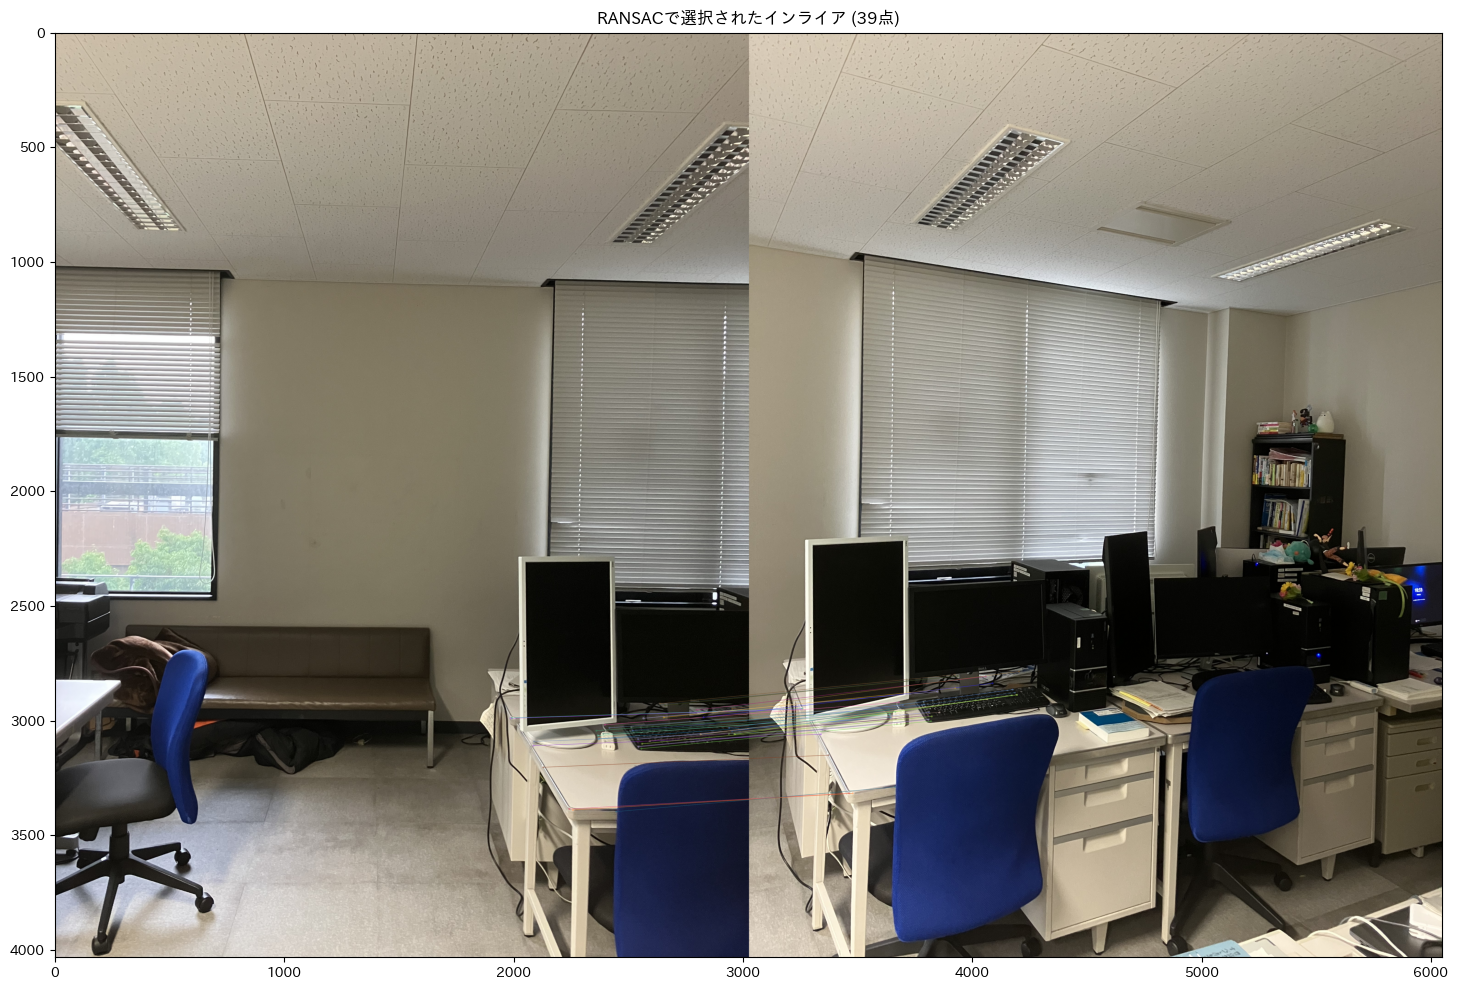

元の対応点数: 399
RANSACで選択されたインライア数: 39
インライア比率: 9.8%


In [14]:
# マッチングした特徴点から対応点を取得
src_pts = np.float32([kp_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# RANSACでホモグラフィ行列を計算し、インライアを特定
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# インライアのみを抽出
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i][0] == 1]

# マッチング結果の可視化（インライアのみ）
plt.figure(figsize=(15, 10))

# オリジナルのマッチング
# plt.subplot(211)
# img_matches_all = cv2.drawMatches(img_left, kp_left, img_right, kp_right, good_matches, None,
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(cv2.cvtColor(img_matches_all, cv2.COLOR_BGR2RGB))
# plt.title(f'全てのマッチング ({len(good_matches)}点)')

# インライアのみのマッチング
plt.subplot(111)
img_matches_inliers = cv2.drawMatches(img_left, kp_left, img_right, kp_right, inlier_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(img_matches_inliers, cv2.COLOR_BGR2RGB))
plt.title(f'RANSACで選択されたインライア ({len(inlier_matches)}点)')

plt.tight_layout()
plt.show()

# マッチングの詳細情報を表示
print(f"元の対応点数: {len(good_matches)}")
print(f"RANSACで選択されたインライア数: {len(inlier_matches)}")
print(f"インライア比率: {len(inlier_matches)/len(good_matches)*100:.1f}%")

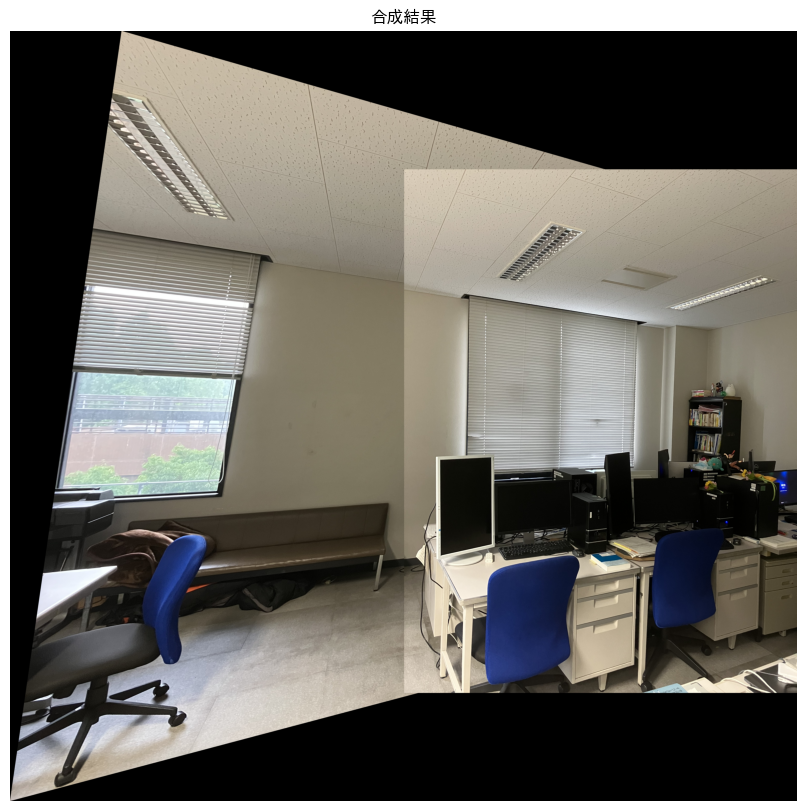

合成画像のサイズ: (5929, 6058)


In [4]:
# マッチングした特徴点から対応点を取得
src_pts = np.float32([kp_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# ホモグラフィ行列を計算
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 画像のサイズを取得
h1, w1 = img_left.shape[:2]
h2, w2 = img_right.shape[:2]

# 変換後の画像サイズを計算
pts = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
dst = np.int32(dst)

# 合成画像のサイズを計算
x_min = min(dst[:, 0, 0].min(), 0)
x_max = max(dst[:, 0, 0].max(), w2)
y_min = min(dst[:, 0, 1].min(), 0)
y_max = max(dst[:, 0, 1].max(), h2)

# 平行移動行列を作成
offset = [-x_min, -y_min]
H_translation = np.array([[1, 0, offset[0]], [0, 1, offset[1]], [0, 0, 1]])
H_final = H_translation.dot(H)

# 最終的な画像サイズ
size = (x_max - x_min, y_max - y_min)

# 画像を合成
result = cv2.warpPerspective(img_left, H_final, size)
result[-y_min:h2-y_min, -x_min:w2-x_min] = img_right

# 結果の表示
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('合成結果')
plt.axis('off')
plt.show()

# 合成画像のサイズを表示
print(f"合成画像のサイズ: {result.shape[:2]}")

In [7]:
# 左画像を変換
warped_left = cv2.warpPerspective(img_left, H_final, size)

# 右画像を配置
warped_right = np.zeros_like(warped_left)
warped_right[-y_min:h2-y_min, -x_min:w2-x_min] = img_right


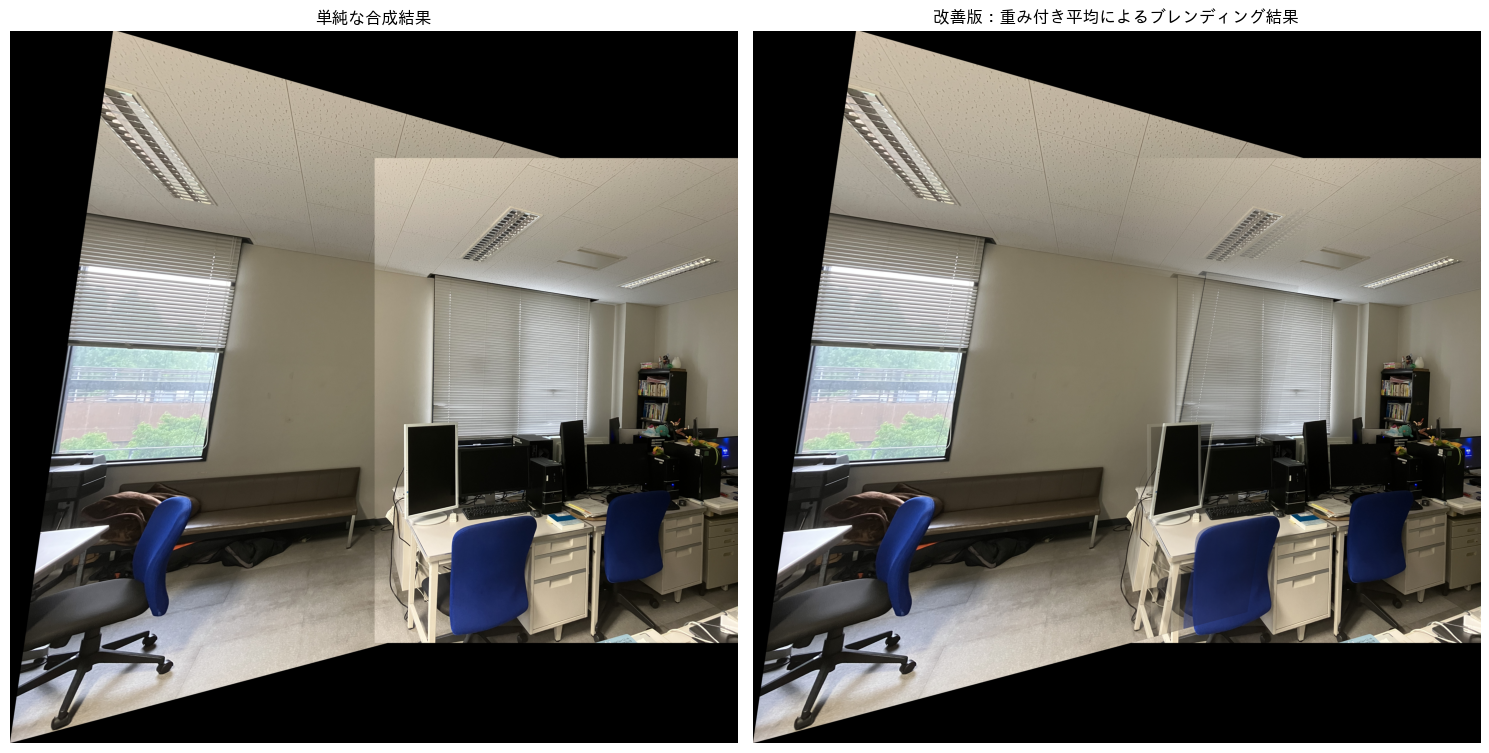

合成画像のサイズ: (5929, 6058)


In [8]:
def improved_blend_images(warped_left, warped_right, overlap_width=200):
    """
    改善版：2つの画像を重み付き平均でブレンディングする関数
    """
    height, width = warped_left.shape[:2]
    
    # マスクの作成（重なり合う領域を特定）
    mask_left = (warped_left != 0).any(axis=2)
    mask_right = (warped_right != 0).any(axis=2)
    overlap_mask = mask_left & mask_right
    
    # 重み付けマスクの作成
    weight_mask = np.zeros((height, width))
    
    # オーバーラップ領域の座標を取得
    y_coords, x_coords = np.where(overlap_mask)
    if len(x_coords) == 0:
        return warped_left + warped_right
    
    x_min, x_max = x_coords.min(), x_coords.max()
    overlap_width = x_max - x_min
    
    # グラデーションの重みを計算
    for x in range(x_min, x_max + 1):
        weight = (x - x_min) / overlap_width
        weight_mask[:, x] = weight
    
    # 3チャンネル用に拡張
    weight_mask = np.stack([weight_mask] * 3, axis=2)
    
    # 重み付き平均の計算
    blended = np.zeros_like(warped_left, dtype=np.float32)
    overlap_region = overlap_mask[:, :, np.newaxis]
    
    # オーバーラップ領域でブレンディング
    blended += warped_left * (1 - weight_mask) * overlap_region
    blended += warped_right * weight_mask * overlap_region
    
    # 非オーバーラップ領域の処理
    non_overlap_left = mask_left & ~overlap_mask
    non_overlap_right = mask_right & ~overlap_mask
    blended += warped_left * non_overlap_left[:, :, np.newaxis]
    blended += warped_right * non_overlap_right[:, :, np.newaxis]
    
    return blended.astype(np.uint8)

# ブレンディングの実行と結果の表示
result_improved = improved_blend_images(warped_left, warped_right)

# 結果の比較表示
plt.figure(figsize=(15, 10))

# 単純な合成結果
plt.subplot(121)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('単純な合成結果')
plt.axis('off')

# 改善版のブレンディング結果
plt.subplot(122)
plt.imshow(cv2.cvtColor(result_improved, cv2.COLOR_BGR2RGB))
plt.title('改善版：重み付き平均によるブレンディング結果')
plt.axis('off')

plt.tight_layout()
plt.show()

# 合成画像のサイズを表示
print(f"合成画像のサイズ: {result_improved.shape[:2]}")